# Development Environment

In [ ]:
!pip install -r requirements.txt

In [1]:
from utils.jupyter_utils import log_cell
from utils.jupyter_utils import clear_logs

In [2]:
clear_logs()

## Execution

In [ ]:
!python split_data.py run res/train.json --ratio=0.2 --suffix="02"

In [ ]:
!python split_data.py run res/train.json --ratio=0.002 --suffix="0002"

In [ ]:
!python split_data.py run res/train.json --ratio=0.001 --suffix="0001"

In [ ]:
%%log_cell

# 자가 테스트용
!python grape_recommender.py run \
    --song_meta_fname=res/song_meta.json \
    --genre_fname=res/genre_gn_all.json \
    --train_fname=arena_data/orig/train.json \
    --question_fname=arena_data/questions/val.json

In [ ]:
%%log_cell

# 자가 테스트용 채점
!python evaluate.py evaluate \
    --gt_fname=arena_data/answers/val.json \
    --rec_fname=arena_data/results/results.json

In [ ]:
%%log_cell

# 리더보드 제출용
!python grape_recommender.py run \
    --song_meta_fname=res/song_meta.json \
    --genre_fname=res/genre_gn_all.json \
    --train_fname=res/train.json \
    --question_fname=res/val.json

In [ ]:
%%log_cell

# 최종 제출용
!python grape_recommender.py run \
    --song_meta_fname=res/song_meta.json \
    --genre_fname=res/genre_gn_all.json \
    --train_fname=res/train.json \
    --question_fname=res/test.json

## Development

In [3]:
%load_ext autoreload
%autoreload 2
# %autoreload 1

In [4]:
def prepare_data(suffix=''):
    if not suffix:
        return
    import shutil
    shutil.copyfile(f"./arena_data/orig/train{suffix}.json", "./arena_data/orig/train.json")
    shutil.copyfile(f"./arena_data/orig/val{suffix}.json", "./arena_data/orig/val.json")
    shutil.copyfile(f"./arena_data/questions/val{suffix}.json", "./arena_data/questions/val.json")
    shutil.copyfile(f"./arena_data/answers/val{suffix}.json", "./arena_data/answers/val.json")

In [5]:
# prepare_data("02")
prepare_data("0002")
# prepare_data("0001")

In [6]:
from utils import read_json
from utils import write_json

In [7]:
train = read_json('./arena_data/orig/train.json')
genre_gn_all = read_json('./res/genre_gn_all.json')
song_meta = read_json('./res/song_meta.json')

In [ ]:
# 제출용
train = read_json('./res/train.json')
genre_gn_all = read_json('./res/genre_gn_all.json')
song_meta = read_json('./res/song_meta.json')

In [8]:
%%log_cell
%%time
import lib.graph
%aimport -lib.graph

graph = lib.graph.GraphBuilder().build(song_meta, genre_gn_all, train)

Building edges: 100%|##########| 823084/823084 [01:19<00:00, 10388.65it/s]


CPU times: user 1min 38s, sys: 2.22 s, total: 1min 41s
Wall time: 1min 40s


In [10]:
import pickle

with open('model.pkl', 'wb') as f:
    pickle.dump(graph, f, protocol=4)

In [9]:
%%log_cell
%%time
import lib.grape
%aimport lib.grape.models.graph_spread
from constants import NUM_OF_RECOMMENDED_SONGS
from constants import NUM_OF_RECOMMENDED_TAGS

grape = lib.grape.Grape(
    graph,
    NUM_OF_RECOMMENDED_SONGS,
    NUM_OF_RECOMMENDED_TAGS,
)

Caching edges: 100%|##########| 25282028/25282028 [02:24<00:00, 175213.04it/s]
Caching union nodes: 4073657it [01:30, 45125.27it/s]                             

CPU times: user 4min 24s, sys: 6.17 s, total: 4min 31s
Wall time: 4min 28s


In [10]:
%%log_cell
%%time
grape.fit(train)

Fitting MostPopular model: 100%|##########| 114841/114841 [00:15<00:00, 7240.53it/s]


CPU times: user 17.2 s, sys: 121 ms, total: 17.4 s
Wall time: 17.2 s


In [11]:
questions = read_json('./arena_data/questions/val.json')
answers = read_json('./arena_data/answers/val.json')

In [ ]:
# 제출용
questions = read_json('./res/val.json')

In [13]:
%%log_cell

def predict_multi(grape, questions, jobs=1):
    import multiprocessing as mp
    import numpy as np
    import itertools

    if jobs is None:
        jobs = mp.cpu_count()
    
    if jobs > 1:
        chunks = list(np.array_split(questions, jobs))

        with mp.Pool() as pool:
            results = pool.map(predict_job, chunks)
            return list(itertools.chain(*results))
    else:
        return predict_job(grape, questions)

def predict_job(q):
    return grape.predict_all(q)

In [28]:
%%log_cell
%%time
from utils import validate_answers

n_questions = 2000000000
# n_questions = 200
# n_questions = 100
# answers = grape.predict_all(questions[:n_questions])
results = predict_multi(grape, questions[:n_questions], jobs=12)
validate_answers(results, questions[:n_questions])
write_json(results, './arena_data/results/results.json')

!python evaluate.py evaluate \
    --gt_fname=arena_data/answers/val.json \
    --rec_fname=arena_data/results/results.json \
    --question_fname=arena_data/questions/val.json

100%|##########| 10/10 [00:08<00:00,  1.16it/s]


[Warning] 제출한 정답이 부족합니다.
=== Total score ===
Music nDCG: 0.252894
Tag nDCG: 0.466986
Score: 0.285007
=== SONG_TAG score ===
Music nDCG: 0.332553
Tag nDCG: 0.591763
Score: 0.371435
=== TAG_TITLE score ===
Music nDCG: 0.014876
Tag nDCG: 0.6
Score: 0.102645
=== SONG_ONLY score ===
Music nDCG: 0.248628
Tag nDCG: 0.363654
Score: 0.265882
=== TITLE_ONLY score ===
Music nDCG: 0.373144
Tag nDCG: 0.166667
Score: 0.342172
CPU times: user 55.1 ms, sys: 1.1 s, total: 1.15 s
Wall time: 10.6 s


In [ ]:
%%log_cell
from utils import validate_answers

n_questions = 2000
# n_questions = 200
# n_questions = 100
results = grape.predict_all(questions[:n_questions])
validate_answers(results, questions[:n_questions])
write_json(results, './arena_data/results/results.json')

!python evaluate.py evaluate \
    --gt_fname=arena_data/answers/val.json \
    --rec_fname=arena_data/results/results.json \
    --question_fname=arena_data/questions/val.json

In [ ]:
%%log_cell
from utils import validate_answers

n_questions = 2000
# n_questions = 200
# n_questions = 100
results = grape.predict_all(questions[:n_questions])
validate_answers(results, questions[:n_questions])
write_json(results, './arena_data/results/results.json')

!python evaluate.py evaluate \
    --gt_fname=arena_data/answers/val.json \
    --rec_fname=arena_data/results/results.json \
    --question_fname=arena_data/questions/val.json

  0%|          | 0/1 [00:00<?, ?it/s]

=== questions ===
[{'tags': ['뉴에이지', '재즈'], 'id': 20353, 'plylst_title': '', 'songs': [129962, 239826, 18663, 409769, 184162, 122035, 47735, 10851, 303903, 368771, 45923, 279741, 489174, 87876], 'like_cnt': 10, 'updt_date': '2016-05-24 10:10:32.000'}]

=== answers ===
[{'tags': ['카페', '피아노', '봄'], 'id': 20353, 'plylst_title': '따뜻한 봄날의 달달한 피아노 뮤직', 'songs': [376537, 238465, 32116, 241758, 394738, 138251, 573337, 288942, 553099, 434503, 175027, 1238, 491855, 670743, 86289], 'like_cnt': 10, 'updt_date': '2016-05-24 10:10:32.000'}]

=== moved weights (6743) ===
AlbumNode(2672081): 0.045
ArtistNode(906972): 0.045
ArtistNode(180128): 0.045
MonthNode(3): 0.04
YearNode(2015): 0.04
YearNode(2016): 0.03
ArtistNode(712152): 0.03
PlaylistNode(90992): 0.03
ArtistNode(774540): 0.03
ArtistNode(498353): 0.03
PlaylistNode(83972): 0.027500000000000004
PlaylistNode(62814): 0.027500000000000004
PlaylistNode(117121): 0.027500000000000004
PlaylistNode(22937): 0.027500000000000004
PlaylistNode(76295): 0.0275

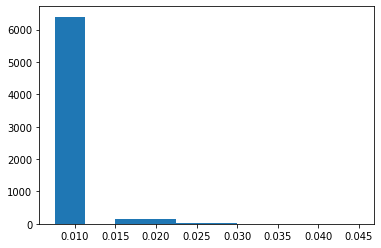

=== moved weights (174478) ===
TagNode(뉴에이지): 0.006875000000000003
TagNode(재즈): 0.006875000000000003
TagNode(피아노): 0.003437500000000001
WordNode(피아노): 0.0028125000000000003
TagNode(잔잔한): 0.0027500000000000007
TagNode(기분전환): 0.0020625000000000005
TagNode(오후): 0.0013750000000000004
WordNode(멜로디): 0.0013750000000000004
TagNode(팝): 0.0013750000000000004
TagNode(클래식): 0.0013750000000000004
WordNode(잔잔한): 0.0013750000000000004
TagNode(봄): 0.0013750000000000004
WordNode(감성): 0.0013750000000000004
TagNode(겨울): 0.0013750000000000004
TagNode(힐링): 0.0013750000000000004
SongNode(303903): 0.0012000000000000001
SongNode(184162): 0.00115
SongNode(10851): 0.0011250000000000001
SongNode(122035): 0.0011250000000000001
SongNode(18663): 0.001075
SongNode(30280): 0.001075
SongNode(32116): 0.001075
SongNode(65864): 0.001075
SongNode(110888): 0.001075
SongNode(129962): 0.001075
SongNode(155805): 0.001075
SongNode(159856): 0.001075
SongNode(172461): 0.001075
SongNode(236627): 0.001075
SongNode(238465): 0.0010

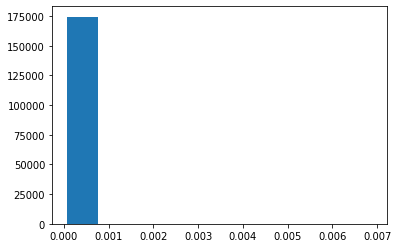

=== moved weights (16911) ===
PlaylistNode(107548): 0.00022750000000000008
PlaylistNode(125485): 0.00022750000000000008
PlaylistNode(84463): 0.00020000000000000006
PlaylistNode(83972): 0.00020000000000000006
PlaylistNode(2828): 0.00020000000000000006
PlaylistNode(148131): 0.00020000000000000006
PlaylistNode(102991): 0.00020000000000000006
PlaylistNode(97525): 0.00020000000000000006
PlaylistNode(84325): 0.00020000000000000006
PlaylistNode(95928): 0.00020000000000000006
PlaylistNode(96461): 0.00020000000000000006
PlaylistNode(140864): 0.00020000000000000006
PlaylistNode(149900): 0.0001993750000000001
PlaylistNode(117121): 0.0001993750000000001
PlaylistNode(88795): 0.0001993750000000001
PlaylistNode(110913): 0.0001993750000000001
PlaylistNode(35507): 0.0001993750000000001
PlaylistNode(99664): 0.0001993750000000001
PlaylistNode(82165): 0.0001993750000000001
PlaylistNode(47772): 0.0001993750000000001
PlaylistNode(117967): 0.0001993750000000001
PlaylistNode(89290): 0.0001993750000000001
Play

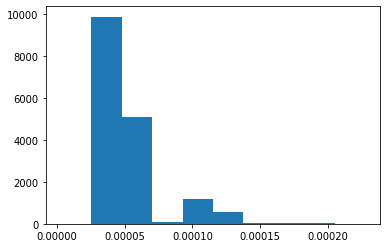

=== moved weights (1103) ===
TagNode(재즈): 0.00018978125000000023
TagNode(뉴에이지): 0.00018978125000000023
TagNode(피아노): 0.0001849531250000002
TagNode(힐링): 7.357812500000004e-05
TagNode(잔잔한): 7.103125000000005e-05
TagNode(연주곡): 6.642187500000003e-05
WordNode(피아노): 6.620312500000002e-05
TagNode(클래식): 5.285937500000002e-05
WordNode(연주곡): 4.715625000000002e-05
WordNode(좋은): 3.770312500000002e-05
TagNode(기분전환): 3.2843750000000016e-05
TagNode(겨울): 2.785937500000001e-05
TagNode(카페): 2.2875000000000007e-05
TagNode(휴식): 2.285937500000001e-05
WordNode(선율): 1.998437500000001e-05
WordNode(함께): 1.9968750000000008e-05
TagNode(커피): 1.9281250000000008e-05
TagNode(가을): 1.9281250000000008e-05
TagNode(연주): 1.8593750000000008e-05
WordNode(듣기): 1.8421875000000006e-05
WordNode(한): 1.5656250000000008e-05
WordNode(감성): 1.4968750000000008e-05
TagNode(봄): 1.4968750000000006e-05
TagNode(새벽): 1.4953125000000008e-05
WordNode(잔잔한): 1.4953125000000008e-05
TagNode(감성): 1.4281250000000005e-05
WordNode(듣는): 1.359375000000

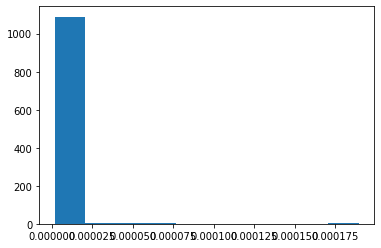

=== moved weights (23445) ===
PlaylistNode(110913): 7.091250000000008e-06
PlaylistNode(35507): 7.091250000000008e-06
PlaylistNode(82165): 7.091250000000008e-06
PlaylistNode(47772): 7.091250000000008e-06
PlaylistNode(89290): 7.091250000000008e-06
PlaylistNode(14894): 7.091250000000008e-06
PlaylistNode(17956): 6.380937500000007e-06
PlaylistNode(14471): 6.380937500000007e-06
PlaylistNode(33816): 6.380937500000007e-06
PlaylistNode(12846): 6.380937500000007e-06
PlaylistNode(113519): 6.380937500000007e-06
PlaylistNode(76581): 6.380937500000007e-06
PlaylistNode(74439): 6.380937500000007e-06
PlaylistNode(45236): 6.380937500000007e-06
PlaylistNode(148965): 6.380937500000007e-06
PlaylistNode(102991): 6.380937500000007e-06
PlaylistNode(130832): 6.380937500000007e-06
PlaylistNode(92841): 6.380937500000007e-06
PlaylistNode(21190): 6.380937500000007e-06
PlaylistNode(1215): 6.380937500000007e-06
PlaylistNode(47850): 6.380937500000007e-06
PlaylistNode(143120): 6.380937500000007e-06
PlaylistNode(48958)

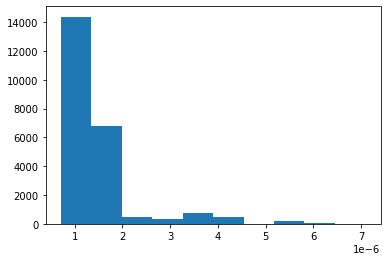

=== moved weights (1581) ===
TagNode(재즈): 9.129968750000012e-06
TagNode(뉴에이지): 9.129968750000012e-06
TagNode(피아노): 8.998925781250012e-06
TagNode(힐링): 4.066152343750006e-06
TagNode(연주곡): 3.3046289062500053e-06
TagNode(잔잔한): 2.3069375000000025e-06
TagNode(기분전환): 2.0351054687500025e-06
TagNode(클래식): 1.980558593750002e-06
WordNode(피아노): 1.7474570312500019e-06
TagNode(겨울): 1.6983007812500016e-06
WordNode(연주곡): 1.6431171875000016e-06
TagNode(카페): 1.6152734375000018e-06
WordNode(좋은): 1.5026250000000016e-06
TagNode(휴식): 1.4160429687500014e-06
TagNode(커피): 1.1835781250000012e-06
TagNode(봄): 9.37472656250001e-07
WordNode(뉴에이지): 9.01957031250001e-07
WordNode(듣는): 9.01957031250001e-07
WordNode(함께): 9.006835937500011e-07
TagNode(새벽): 8.141015625000009e-07
TagNode(가을): 7.601914062500008e-07
TagNode(연주): 7.42433593750001e-07
TagNode(감성): 7.317109375000009e-07
WordNode(감성): 6.368203125000008e-07
WordNode(때): 6.368203125000008e-07
WordNode(듣기): 6.196992187500008e-07
TagNode(매장음악): 6.013046875000007e-07

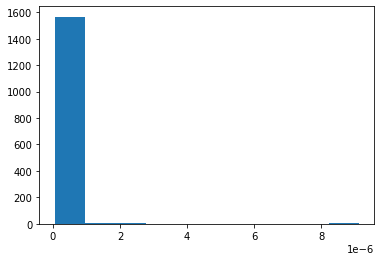

=== moved weights (16250) ===
PlaylistNode(33816): 3.4629644531250046e-07
PlaylistNode(76581): 3.4629644531250046e-07
PlaylistNode(110913): 3.4629644531250046e-07
PlaylistNode(102991): 3.4629644531250046e-07
PlaylistNode(92841): 3.4629644531250046e-07
PlaylistNode(143120): 3.4629644531250046e-07
PlaylistNode(48958): 3.4629644531250046e-07
PlaylistNode(17956): 3.132501562500004e-07
PlaylistNode(14471): 3.132501562500004e-07
PlaylistNode(12846): 3.132501562500004e-07
PlaylistNode(113519): 3.132501562500004e-07
PlaylistNode(74439): 3.132501562500004e-07
PlaylistNode(45236): 3.132501562500004e-07
PlaylistNode(148965): 3.132501562500004e-07
PlaylistNode(35507): 3.132501562500004e-07
PlaylistNode(130832): 3.132501562500004e-07
PlaylistNode(82165): 3.132501562500004e-07
PlaylistNode(21190): 3.132501562500004e-07
PlaylistNode(47772): 3.132501562500004e-07
PlaylistNode(1215): 3.132501562500004e-07
PlaylistNode(47850): 3.132501562500004e-07
PlaylistNode(89290): 3.132501562500004e-07
PlaylistNode

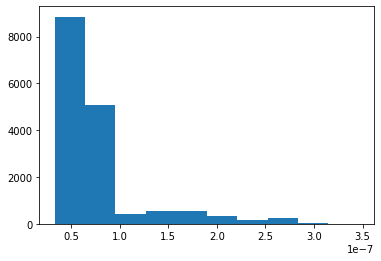

=== moved weights (2297) ===
TagNode(피아노): 5.721389853515627e-07
TagNode(뉴에이지): 5.402971513671877e-07
TagNode(재즈): 4.892977998046876e-07
TagNode(힐링): 3.276392529296878e-07
TagNode(연주곡): 3.09121032226563e-07
TagNode(잔잔한): 1.5536943359375022e-07
WordNode(연주곡): 1.356528583984377e-07
TagNode(휴식): 1.3365933203125017e-07
TagNode(카페): 1.327018291015627e-07
TagNode(기분전환): 1.2635407226562516e-07
TagNode(클래식): 1.1074500097656266e-07
WordNode(피아노): 1.0604867089843765e-07
TagNode(겨울): 9.794172656250014e-08
WordNode(좋은): 9.074624902343763e-08
TagNode(감성): 7.455214843750011e-08
WordNode(듣는): 7.02637421875001e-08
TagNode(매장음악): 7.00199248046876e-08
TagNode(커피): 6.457803613281259e-08
TagNode(새벽): 5.790026464843758e-08
TagNode(봄): 5.279129980468758e-08
WordNode(뉴에이지): 5.279129980468757e-08
WordNode(함께): 4.913866992187507e-08
TagNode(연주): 4.330773144531256e-08
TagNode(가을): 4.330773144531256e-08
WordNode(잔잔한): 4.242813769531256e-08
TagNode(집중): 4.097180273437506e-08
WordNode(듣기): 3.9161868164062554e-08
W

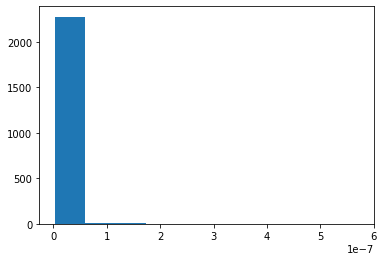

100%|##########| 1/1 [00:03<00:00,  3.67s/it]


=== questions ===
[{'tags': ['뉴에이지', '재즈'], 'id': 20353, 'plylst_title': '', 'songs': [129962, 239826, 18663, 409769, 184162, 122035, 47735, 10851, 303903, 368771, 45923, 279741, 489174, 87876], 'like_cnt': 10, 'updt_date': '2016-05-24 10:10:32.000'}]

=== answers ===
[{'tags': ['카페', '피아노', '봄'], 'id': 20353, 'plylst_title': '따뜻한 봄날의 달달한 피아노 뮤직', 'songs': [376537, 238465, 32116, 241758, 394738, 138251, 573337, 288942, 553099, 434503, 175027, 1238, 491855, 670743, 86289], 'like_cnt': 10, 'updt_date': '2016-05-24 10:10:32.000'}]

=== results ===
{'id': 20353, 'songs': [238465, 30280, 32116, 65864, 110888, 155805, 159856, 172461, 236627, 241758, 274736, 307148, 315100, 332438, 352318, 365476, 407558, 426944, 463193, 482497, 515963, 532325, 535765, 571818, 585075, 632959, 478926, 373832, 389563, 381403, 265032, 704882, 356614, 113358, 219082, 273499, 644497, 504360, 124428, 210956, 687595, 226587, 275925, 171429, 487760, 494259, 511209, 427437, 577874, 666121, 139805, 242948, 284408, 3016

In [21]:
%%log_cell
from utils import validate_answers

question_id = 15

print("=== questions ===")
print(questions[question_id:question_id+1])
print()

print("=== answers ===")
print(answers[question_id:question_id+1])
print()

results = grape.predict_all(questions[question_id:question_id+1])
validate_answers(results, questions[question_id:question_id+1])
write_json(results, './arena_data/results/results.json')

print("=== questions ===")
print(questions[question_id:question_id+1])
print()

print("=== answers ===")
print(answers[question_id:question_id+1])
print()

print("=== results ===")
print(results[0])
print()

!python evaluate.py evaluate \
    --gt_fname=arena_data/answers/val.json \
    --rec_fname=arena_data/results/results.json \
    --question_fname=arena_data/questions/val.json

In [ ]:
%%log_cell
from utils import validate_answers

question_id = 18

print("=== questions ===")
print(questions[question_id:question_id+1])
print()

print("=== answers ===")
print(answers[question_id:question_id+1])
print()

results = grape.predict_all(questions[question_id:question_id+1])
validate_answers(results, questions[question_id:question_id+1])
write_json(results, './arena_data/results/results.json')

print("=== questions ===")
print(questions[question_id:question_id+1])
print()

print("=== answers ===")
print(answers[question_id:question_id+1])
print()

print("=== results ===")
print(results[0])
print()

!python evaluate.py evaluate \
    --gt_fname=arena_data/answers/val.json \
    --rec_fname=arena_data/results/results.json \
    --question_fname=arena_data/questions/val.json

## Test

In [ ]:
%%time
import lib.graph
%aimport -lib.graph.core
%aimport  lib.graph.core.graph
%aimport -lib.graph.nodes

graph = lib.graph.GraphBuilder().build(song_meta[:100], genre_gn_all, [])

In [ ]:
%%time
import lib.grape
from constants import NUM_OF_RECOMMENDED_SONGS
from constants import NUM_OF_RECOMMENDED_TAGS

grape = lib.grape.Grape(
    graph,
    NUM_OF_RECOMMENDED_SONGS,
    NUM_OF_RECOMMENDED_TAGS,
)

In [ ]:
grape.fit(train)

In [ ]:
questions = read_json('./arena_data/questions/val.json')

In [ ]:
from utils import validate_answers

n_questions = 20
answers = grape.predict_all(questions[:n_questions])
validate_answers(answers, questions[:n_questions])
write_json(answers, './arena_data/results/results.json')

!python evaluate.py evaluate \
    --gt_fname=arena_data/answers/val.json \
    --rec_fname=arena_data/results/results.json

## Playground